In [1]:
# Importations initiales
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

# Chargement du jeu de données Allociné
dataset = load_dataset("tblard/allocine")

# Conversion en DataFrame
df = pd.DataFrame(dataset['train'])

# 👀 Aperçu du dataset
df.head()


d:\master\nlp_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\master\nlp_project\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\datasets--tblard--allocine. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this 

,review,label
0,Si vous cherchez du cinéma abrutissant à tous ...,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,"Et si, dans les 5 premières minutes du film, l...",0
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1


## la répartition des classes

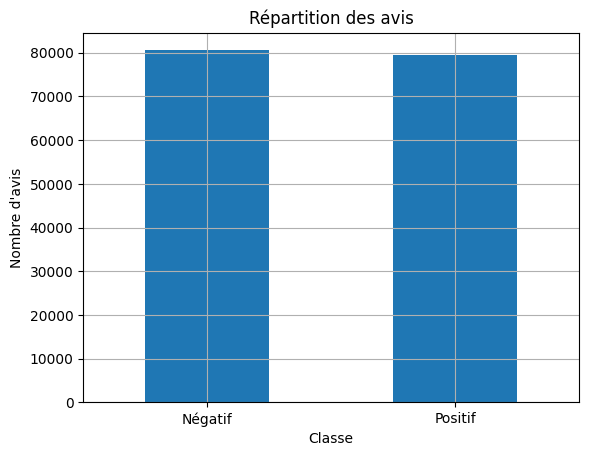

In [2]:
# Distribution des classes (0 = négatif, 1 = positif)
df['label'].value_counts().plot(kind='bar', title='Répartition des avis')
plt.xticks([0, 1], ['Négatif', 'Positif'], rotation=0)
plt.xlabel('Classe')
plt.ylabel('Nombre d\'avis')
plt.grid(True)
plt.show()

## Prétraitement avec spacy

In [13]:
import spacy

# Chargement du modèle français
nlp = spacy.load("fr_core_news_sm")

def nettoyer_spacy(texte):
    doc = nlp(texte)
    tokens = [token.lemma_.lower() for token in doc 
              if not token.is_stop and not token.is_punct and len(token) > 2]
    return " ".join(tokens)

# Application de la fonction de nettoyage
df['texte_nettoye'] = df['review'].apply(nettoyer_spacy)

# Affichage avant/après
df[['review', 'texte_nettoye']].sample(5)





,review,texte_nettoye
110193,"Tombé dessus par hasard, ce matou pas comme le...",tomber hasard matou plaire aventure aventure g...
126711,Daniel Day-Lewis est vraiment un dieu!! Quel a...,daniel day lewis vraiment dieu acteur vraiment...
31735,Film moyen.,film moyen
48929,un chef d'oeuvre. le fameux docteur lecter sor...,chef oeuvre fameu docteur lecter sort tanière ...
109741,"Etant un fan de films de zombies, je me devais...",fan film zombie devoir regarder film bilan cou...


## Vectorisation    

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialisation du vectoriseur TF-IDF
vectoriseur = TfidfVectorizer(max_features=5000)  # On limite à 5000 mots les plus fréquents

# Création des vecteurs TF-IDF
X = vectoriseur.fit_transform(df['texte_nettoye'])

# Les étiquettes (0 = négatif, 1 = positif)
y = df['label']


## Séparation des données train et test

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Entraînement & Évaluation du modèle : comparaison Reg logistique et SVM

Accuracy : 0.9106875
F1-score : 0.911806455594643

Classification Report :
               precision    recall  f1-score   support

           0       0.91      0.90      0.91     15883
           1       0.91      0.92      0.91     16117

    accuracy                           0.91     32000
   macro avg       0.91      0.91      0.91     32000
weighted avg       0.91      0.91      0.91     32000



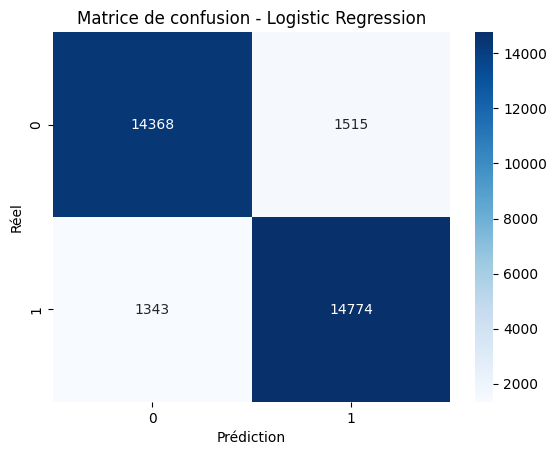

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 🔁 Initialisation et entraînement
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(X_train, y_train)

# 🎯 Prédictions
y_pred = clf.predict(X_test)

# 📊 Évaluation
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

# 📉 Matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Logistic Regression")
plt.show()


✅ [SVM] Accuracy : 0.90903125
✅ [SVM] F1-score : 0.9098901098901099

📋 [SVM] Classification Report :
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     15883
           1       0.91      0.91      0.91     16117

    accuracy                           0.91     32000
   macro avg       0.91      0.91      0.91     32000
weighted avg       0.91      0.91      0.91     32000



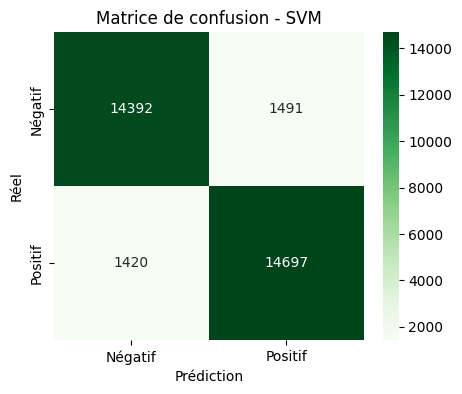

In [17]:
from sklearn.svm import LinearSVC

# 🔁 Entraînement SVM linéaire
svm_clf = LinearSVC(max_iter=1000, random_state=42)
svm_clf.fit(X_train, y_train)

# 🔮 Prédictions
y_pred_svm = svm_clf.predict(X_test)

# 📈 Évaluation
print("✅ [SVM] Accuracy :", accuracy_score(y_test, y_pred_svm))
print("✅ [SVM] F1-score :", f1_score(y_test, y_pred_svm))
print("\n📋 [SVM] Classification Report :\n", classification_report(y_test, y_pred_svm))

# 📊 Matrice de confusion
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Greens', xticklabels=["Négatif", "Positif"], yticklabels=["Négatif", "Positif"])
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion - SVM")
plt.show()


## Poids mots 

In [18]:
import numpy as np

# Récupérer les mots du vocabulaire TF-IDF
mots = vectoriseur.get_feature_names_out()

# Coefficients du modèle
poids = clf.coef_[0]

# Top mots positifs (poids les plus élevés)
top_pos = np.argsort(poids)[-20:]
print("🔼 Mots les plus positifs :")
for i in reversed(top_pos):
    print(f"{mots[i]} : {poids[i]:.3f}")

# Top mots négatifs (poids les plus faibles)
top_neg = np.argsort(poids)[:20]
print("\n🔽 Mots les plus négatifs :")
for i in top_neg:
    print(f"{mots[i]} : {poids[i]:.3f}")


🔼 Mots les plus positifs :
excellent : 10.627
magnifique : 7.513
superbe : 6.898
bijou : 6.027
adorer : 5.884
merveill : 5.771
bon : 5.762
parfaitement : 5.518
régal : 5.396
bravo : 5.323
sublime : 5.312
remarquable : 5.311
parfaire : 5.237
bémol : 5.210
magistral : 5.120
génial : 5.053
chef : 5.041
meilleur : 4.955
parfait : 4.943
émouvant : 4.916

🔽 Mots les plus négatifs :
ennuyeux : -8.863
déception : -8.328
intérêt : -8.117
ennui : -7.913
décevant : -7.248
mauvais : -6.984
ridicule : -6.918
plat : -6.833
navet : -6.771
rien : -6.747
plv : -6.492
manqu : -6.453
médiocre : -6.389
mauver : -5.978
fade : -5.781
mou : -5.636
malheureusement : -5.469
pire : -5.222
insupportable : -5.202
inintéressant : -5.188


## Nuages de mots

d:\master\nlp_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127785 (\N{CLOUD WITH LIGHTNING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


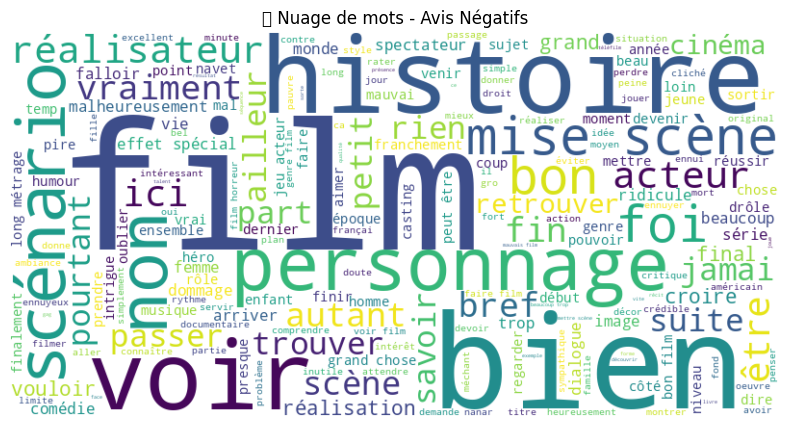

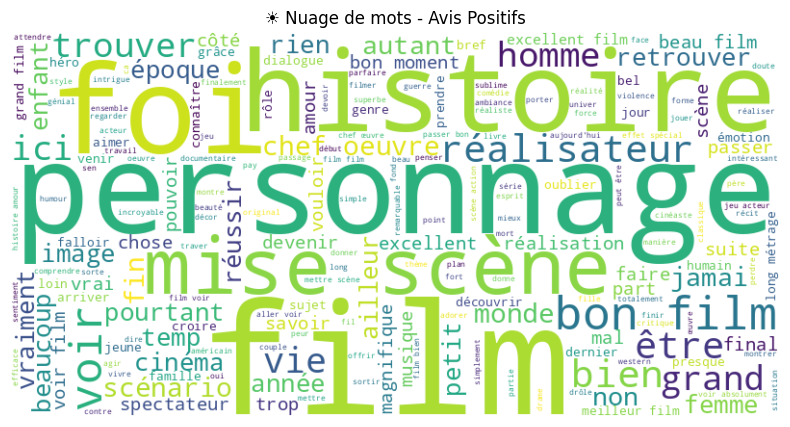

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Générer du texte joint pour chaque classe
texte_negatif = " ".join(df[df['label'] == 0]['texte_nettoye'])
texte_positif = " ".join(df[df['label'] == 1]['texte_nettoye'])

# Nuage de mots - avis négatifs
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(texte_negatif)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("🌩 Nuage de mots - Avis Négatifs")
plt.show()

# Nuage de mots - avis positifs
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(texte_positif)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("☀️ Nuage de mots - Avis Positifs")
plt.show()


### Préparation streamlit 

In [20]:
import joblib
joblib.dump(clf, "modele_logistic_regression.pkl")
joblib.dump(vectoriseur, "vectoriseur_tfidf.pkl")

['vectoriseur_tfidf.pkl']